# Project I: Parameter estimation for a toy model of an effective field theory
## Learning from data [TIF285], Chalmers, Fall 2021

Last revised: 29-Aug-2021 by Christian Forsn [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This project is performed in groups of two students. 
- The second part of the project is optional. See examination rules on the course web page.
- Hand-in your written report and your solution source code via Canvas.
- Students are allowed to discuss together and help each other when working on the projects. However, every student must understand and be able to explain their submitted solutions. Plagiarism (of text and/or code) is not allowed (submissions will be both manually and automatically monitored).

### Written report
- Page limit: 6 pages (excluding title page and list of references). 3 extra pages are allowed when doing also the optional extra task.
- Give a short description of the nature of the problem and the methods you have used.
- Include your results either in figure form or in a table. All tables and figures should have relevant captions and labels on the axes.
- Try to give an interpretation of you results.
- Upload the source code of your program as a separate file (.ipynb or .py). Comment your program properly.

## Main task
The overall project goal is to reproduce various results in a paper: [*Bayesian parameter estimation for effective field theories*](https://arxiv.org/abs/1511.03618).  It's a long paper, so don't try to read all of it!  We'll guide you to the important parts. Sec. II of the paper is the most relevant, but you don't need to understand all of it. 

The paper uses a toy model to simulate an effective field theory (EFT), namely a Taylor series of some specified function. A specific aim is to present guidelines for parameter estimation in the situation where you have some knowledge of the model that can be used in a Bayesian way. We will not discuss the EFT concept in any detail, but will just mention that it is a type of approximation, or effective theory, for a more fundamental (underlying) physical theory. An EFT starts from the relevant degrees of freedom to describe physical phenomena occurring at a chosen length scale or energy scale, while not resolving substructure and degrees of freedom at shorter distances (or, equivalently, at higher energies). 

In our case, the function
$$
g(x) = \left(\frac12 + \tan\left(\frac{\pi}{2}x\right)\right)^2
$$
represents the true, underlying theory.  It has a Taylor expansion
$$
g(x) = 0.25 + 1.57 x + 2.47 x^2 + 1.29 x^3 + \cdots
$$
where the expansion parameters are known in this toy example (since we know the underlying theory) but would not be in a real situation.

Our model for an EFT for this "theory" is then
$$
g_{\rm th}(x) \equiv \sum_{i=0}^k a_i x^i,
$$
where $a_i$ are the parameters of the EFT, sometimes known as low-energy constants (LECs).

Your general task is to fit the parameters $a_i$, up to some truncation order, using a Bayesian approach, and analyze the results. 

* **Your specific goal is to reproduce and interpret Figure 1 on page 6 of the arXiv preprint. This figure shows joint pdfs for the EFT parameters using two different priors. One of these priors encapsulates the physics expectation that the parameters should be of "natural" size (order one).**
* **A secondary goal is to reproduce Figs. 3 and 4 that show predictions of the inferred EFT with error bands. You can either use $k=k_\mathrm{max}=3$ as in the first task, or $k=k_\mathrm{max}=4$ as in the preprint.** 

You should use emcee to sample the joint pdfs and you should use corner to make plots.

### Learning goals:
* Apply and extend the Bayesian parameter estimation ideas and techniques from the course.
* This a less-guided set of tasks and you will have to put together ideas and tools we've discussed.
* Explore the impact of control features:  dependence on how much data is used and how precise it is; apply an *informative* prior.
* Learn about some diagnostics for Bayesian parameter estimation.
* Try out sampling on a controlled problem.

### Suggestions for how to proceed:
* Follow the lead of the exercise notebooks.
* Load the data set that was used in the paper: [D1_c_5.dat](https://arxiv.org/src/1511.03618v3/anc/D1_c_5.dat). The three columns correspond respectively to $x_j$, the measured data $d(x_j) \equiv d_j$ and the error in terms of a standard deviation $\sigma_j$.
* Define functions for the two choices of prior: a wide uniform prior, e.g. $|a_i|<100$, and a Gaussian naturalness prior given by Eq. (24) with $\bar{a}=5$. Use the log prior.
* Define a function for the likelihood (Eq. 9). It will require the chi-squared measure. Use the log likelihood.
* Call emcee to sample the posteriors. 
* Use corner to create plots.  You can read the answers for the tables from the corner plots.
* Don't try to do too much in your code at first (start with a low order). 
* Generate figures for the lowest orders analogous to Figure 1 and then reproduce Figure 1.


### Comments and suggestions
* The `show_titles=True` option to corner will show central results and one-$\sigma$ error limits on the projected posterior plots.
* The `quantiles=[0.16, 0.5, 0.84]`option to corner adds the dashed vertical lines to the marginal posteriors on the diagonal. You can obviously change the quantiles if you want another credibility region.
* The python command `np.percentile(y, [16, 50, 84], axis=0)` might be useful to extract numerical values for the credibility region and the median from a python array `y`.
* When reproducing Figures 3 and 4 you can use Matplotlib's `fill_between(x, y-error, y+error)` to make bands.  (Use the `alpha` keyword for `fill_between`, e.g., `alpha=0.5`, to make the bands more transparent.)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
import corner

sns.set()
sns.set_context("talk")

[[0.03183]
 [0.06366]
 [0.09549]
 [0.12732]
 [0.15915]
 [0.19099]
 [0.22282]
 [0.25465]
 [0.28648]
 [0.31831]]


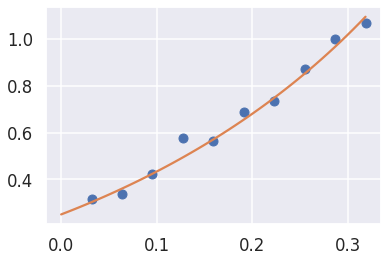

In [8]:
# prepare data
x, data, sigma = np.loadtxt("D1_c_5.dat", unpack=True)
m = len(x)
x = x.reshape(m,1)
data = data.reshape(m,1)
sigma = sigma.reshape(m,1)
print(x)

plt.plot(x, data, 'o')
xx = np.linspace(0, 1/np.pi)
plt.plot(xx, (1/2 + np.tan(np.pi/2*xx))**2)
plt.show()


In [12]:
# define necessary probabilities and functions

def g(x, theta):
    """Polynomial of x with coefficients theta.
    Args:
        x (float): x values
        theta (np.array): coefficients.
    Returns:
        (float): the polynomial evaluated at x."""
    return np.sum([theta[i]*x**i for i in range(len(theta))], axis=0)

def chi_squared(x, data, sigma, theta):
    """Calculate chi^2 from the data given the parameters theta.
    Args:
        x     (np.array): x-values of the measurements, shape (m, 1)
        data  (np.array): y-values of the measurements, shape (m, 1)
        sigma (np.array): error values of the measurements, shape (m, 1)
    Returns:
        float: the chi^2 values."""
    g_vals = np.sum([theta[i]*x**i for i in range(len(theta))], axis=0)
    return np.sum( (data - g_vals)**2/sigma**2 )

def log_prior_gaussian(theta, abar=5):
    """The logarithm of a gaussian prior with width abar and mean zero.
    Args:
        theta (np.array): position at which the prior is evaluated.
        abar (float, optional): width of the gaussian.
    Returns:
        float: log of the gaussian evaluated at theta.
    """
    k = len(theta)
    return k*np.log(1/np.sqrt(2*np.pi*abar**2)) - np.sum(theta**2)/(2*abar**2)

def log_prior_uniform(theta, max_t=100):
    """Flat uniform log prior for the range [-max_t, max_t]
    Args:
        theta (np.array): array of the coefficients.
        max_t (float, optional): maximal absolute value for theta. 
    Returns:
        np.array: the log of the uniform prior.""" 
    min_theta = np.ones(len(theta)) * -max_t
    max_theta = np.ones(len(theta)) * max_t
    volume_theta = np.prod(max_theta-min_theta)
    if np.logical_and(min_theta<=theta, theta<=max_theta).all(): 
        return 0
    else:
        return -np.inf
    


def log_likelihood(x, data, sigma, theta):
    """Logarithm of the chi^2 likelihood.
    Args: 
        x (np.array): x values for the measurements
        data (np.array): y values for the measurement
        sigma (np.array): error for the measurements
        theta (np.array): coefficient values of the polynomial function g.
    Returns:
        float: logarithm of the likelihood evaluated at theta."""
    try:
        return np.sum(-np.log(np.sqrt(2*np.pi*sigma**2))) - chi_squared(x, data, sigma, theta)/2
    except ValueError:
        print("value error")
        return -np.inf


def log_posterior(theta, x, data, sigma, log_prior=log_prior_uniform, max_t=100):
    """Log posterior for measurements given parameter array theta.
    Args:
        theta (np.array): values of the coefficients of the polynomial g
        x (np.array): x values of the measurements
        data (np.array): y values of the measurements
        sigma (np.array): errors of the measurements
        log_prior (function, optional): the log_prior function
        max_t (float, optional): the maximal value for the thetas in the uniform prior
    Returns:
        float: value of the log posterior evaluated at theta."""
    if log_prior == log_prior_uniform:
        return log_prior(theta, max_t) + log_likelihood(x, data, sigma, theta)
    else:
        return log_prior(theta) + log_likelihood(x, data, sigma, theta)


In [13]:
def sample_probabilities(k, x, data, sigma, prior=log_prior_uniform, nwalkers=50, 
                         nburn=1000, nsteps=1000, max_t=100):
    """Use the emcee MCMC sampler to sample the log posterior.
    Args:
        k (int): number of coefficients of the polynomial g
        x (np.array): x values of the measurements
        data (np.array): y values of the measurements
        sigma (np.array): errors of the measurements
        log_prior (function, optional): the log_prior function
        nwalkers (int, optional): number of walkers in the emcee sampling
        nburn (int, optional): number of steps to be burned from the resulting samples
        nsteps (int, optional): number of steps after the burning period
        max_t (float, optional): maximal values for theta for the uniform prior
    Returns:
        np.array: array of samples with shape (nsteps*nwalkers, k)."""
    k_max = k

    min_theta = np.ones(k_max) * -max_t
    max_theta = np.ones(k_max) * max_t
    volume_theta = np.prod(max_theta-min_theta)

    ndim = k  # number of parameters in the model
    nwalkers = 50  # number of MCMC walkers

    # we'll start at random locations within the prior volume
    starting_guesses = min_theta + max_theta * np.random.rand(nwalkers,ndim)

    print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, data, sigma, prior, max_t])
    
    # "burn-in" period; save final positions and then reset
    pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
    sampler.reset()

    # sampling period
    sampler.run_mcmc(pos, nsteps)

    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
          .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

    # discard burn-in points and flatten the walkers;
    # the shape of samples is (nwalkers*nsteps, ndim)
    samples = sampler.chain.reshape((-1, ndim))
    print("Shape of samples: ",samples.shape)
    

    return samples

def plot_parameters(k, samples, truths, param=0):
    # make a corner plot with the posterior distribution
    if not param or param > k:
        k_plot = k
    else:
        k_plot = param
    
    # TODO: remove
    k_plot = k
    
    labels = [r'$a_{:}$'.format(i) for i in range(len(truths))]
    fig = corner.corner(samples[:,:k_plot], labels=labels[:k_plot],
                        truths=truths[:k_plot],quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 12})


    # First, extract the axes
    axes = np.array(fig.axes).reshape((k_plot, k_plot))
    plt.show()

truths = [1/4, np.pi/2, np.pi**2/4,np.pi**3/24, np.pi**4/24, np.pi**5/240, 17*np.pi**6/2880]

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.597 (in total 50000 steps)
Shape of samples:  (50000, 4)


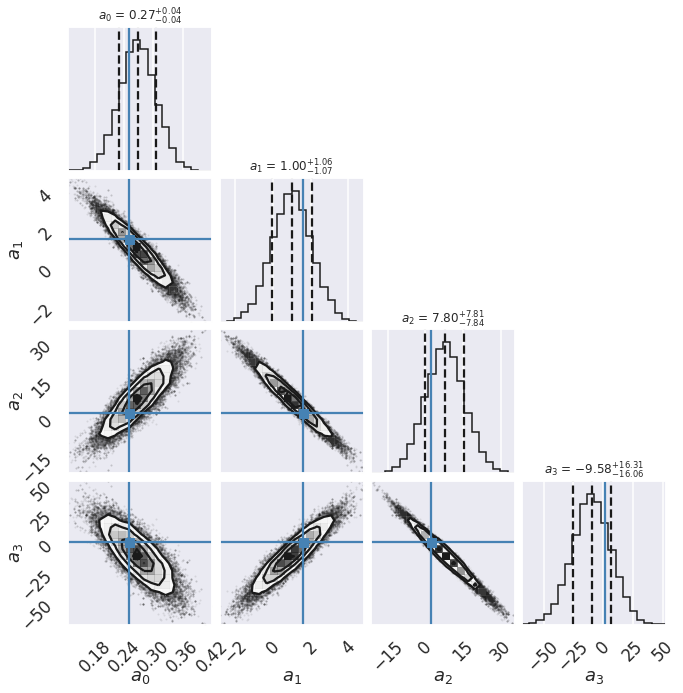

In [17]:
k_1 = 4
samples = sample_probabilities(k_1, x, data, sigma)
m, a, p = np.percentile(samples, [16, 50, 84], axis=0)
plot_parameters(k_1, samples, truths[:k_1])

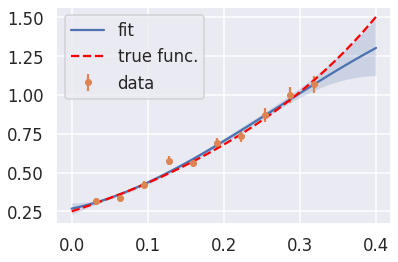

In [18]:
m, a, p = np.percentile(samples, [16, 50, 84], axis=0)
xx = np.linspace(0, 0.4)
def get_g(a):
    return lambda x: sum(a[i]*x**i for i in range(len(a)))

def g_3(x, a):
    return a[0] + a[1]*x[:,np.newaxis] + a[2]*x[:,np.newaxis]**2 + a[3]*x[:,np.newaxis]**3


pred_samples = g_3(xx, [samples[:,0], samples[:,1], samples[:,2], samples[:,3]])
g_low, g_mid, g_high = np.percentile(pred_samples, [16, 50, 84], axis=1)

plt.plot(xx, get_g(a)(xx), label="fit")
g_true = lambda y: (1/2 + np.tan(np.pi/2*y))**2
plt.plot(xx, g_true(xx), '--', color='red',label="true func.")
plt.errorbar(x, data, fmt='o', ms=6,yerr=sigma.flatten(), label="data")
plt.fill_between(xx, g_low, g_high, alpha=0.2)
plt.legend()
plt.show()

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.595 (in total 50000 steps)
Shape of samples:  (50000, 4)


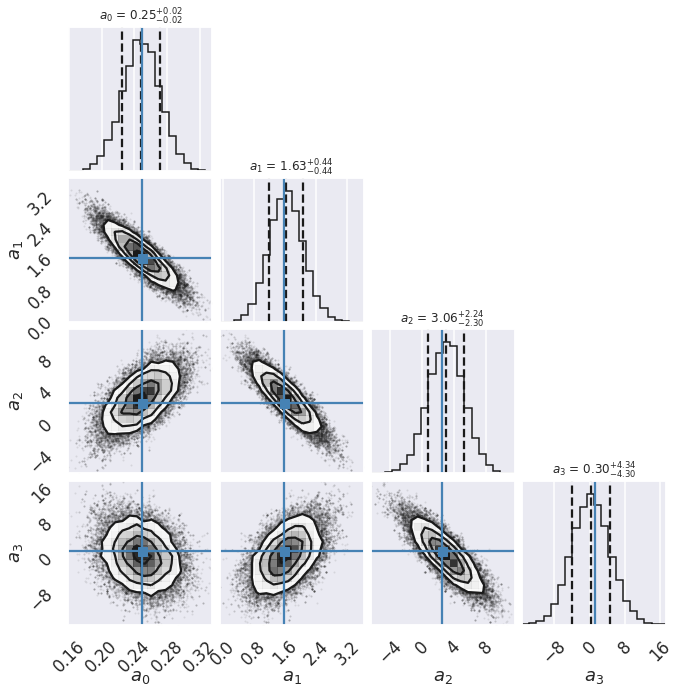

In [19]:
samples = sample_probabilities(k_1, x, data, sigma, prior=log_prior_gaussian)
plot_parameters(k_1, samples, truths[:k_1])

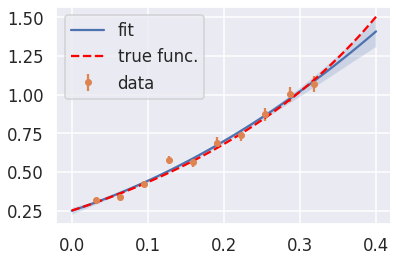

In [20]:
m, a, p = np.percentile(samples, [16, 50, 84], axis=0)
xx = np.linspace(0, 0.4)

pred_samples = g_3(xx, [samples[:,0], samples[:,1], samples[:,2], samples[:,3]])
g_low, g_mid, g_high = np.percentile(pred_samples, [16, 50, 84], axis=1)

plt.plot(xx, get_g(a)(xx), label="fit")
g_true = lambda y: (1/2 + np.tan(np.pi/2*y))**2
plt.plot(xx, g_true(xx), '--', color='red',label="true func.")
plt.errorbar(x, data, fmt='o', ms=6,yerr=sigma.flatten(), label="data")
plt.fill_between(xx, g_low, g_high, alpha=0.2)
plt.legend()
plt.show()

ysis with the same function but different data precision and/or quantity (number of data points). You will then have to generate the data yours
## Optional: Part 2 (extra task)
* Reproduce and interpret Table III on page 12 of the arXiv preprint. 
* Repeat the analysis with the same function but different data precision and/or quantity (number of data points). You will then have to generate the data yourself using Eq. (2) and the true function Eq. (23). It is probably wise to stay in the $0 < x \le 1/\pi$ range.

In [21]:
params_flat = []
samples_flat = []

for k in range(1,8):
    print(f"k_max = {k-1}")
    samples = sample_probabilities(k, x, data, sigma, prior=log_prior_uniform, max_t=500000, 
                                   nburn=1000 ,nsteps=10000)
    samples_flat.append(samples)
    m, a, p = np.percentile(samples, [16, 50, 84], axis=0)
    for i in range(k):
        print("a_{:} = {:2.4f} + {:2.4f} - {:2.4f}".format(i, m[i],a[i],p[i]))
    params_flat.append([a, m, p])
    print("")
    #plot_parameters(k, samples, truths[:k], param=3)
    
print("chi squared")
chi_sq_dof = []
for i in range(len(params_flat)):
    m = len(x)
    chi_sq = chi_squared(x, data, sigma, np.array(params_flat[i][0]))
    chi_sq_dof.append(chi_sq/(m-i-1))
    print(chi_sq/(m-i-1))

def calc_chi_squared(x, data, sigma, params):
    """Calculate the chi^2/dof values for a given parameters.
    Args:
        x (np.array): x values of the measurements
        data (np.array): y values of the measurements
        sigma (np.array): errors of the measurements
        params (list): list of parameter arrays (k_max, [a, m, p]).
    Returns:
        list: list of chi^2/dof values for the different k_max."""
    chi = []
    for i in range(len(params)):
        m = len(x)
        chi_sq = chi_squared(x, data, sigma, np.array(params[i][0]))
        chi.append(chi_sq/(m-i-1))
    return chi

k_max = 0
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.806 (in total 500000 steps)
Shape of samples:  (500000, 1)
a_0 = 0.4672 + 0.4753 - 0.4835

k_max = 1
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.715 (in total 500000 steps)
Shape of samples:  (500000, 2)
a_0 = 0.1895 + 0.2034 - 0.2173
a_1 = 2.4487 + 2.5537 - 2.6596

k_max = 2
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.646 (in total 500000 steps)
Shape of samples:  (500000, 3)
a_0 = 0.2272 + 0.2505 - 0.2733
a_1 = 1.1714 + 1.5716 - 1.9717
a_2 = 2.0232 + 3.3280 - 4.6400

k_max = 3
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.593 (in total 500000 steps)
Shape of samples:  (500000, 4)
a_0 = 0.2302 + 0.2696 - 0.3089
a_1 = -0.1663 + 0.9391 - 2.0472
a_2 = 0.1656 + 8.2964 - 16.4007
a_3 = -27.2888 +

In [22]:
samples_normal = []
params_normal = []

for k in range(1,8):
    print(f"k_max = {k-1}")
    samples = sample_probabilities(k, x, data, sigma, prior=log_prior_gaussian, nburn=1000, nsteps=1000)
    samples_normal.append(samples)
    m, a, p = np.percentile(samples, [16, 50, 84], axis=0)
    params_normal.append([a,m,p])
    for i in range(k):
        print("a_{:} = {:2.4f} + {:2.4f} - {:2.4f}".format(i, m[i],a[i],p[i]))
    print("")
    # plot_parameters(k, samples, truths[:k], param=3)
    

k_max = 0
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.812 (in total 50000 steps)
Shape of samples:  (50000, 1)
a_0 = 0.4672 + 0.4753 - 0.4833

k_max = 1
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.713 (in total 50000 steps)
Shape of samples:  (50000, 2)
a_0 = 0.1898 + 0.2041 - 0.2180
a_1 = 2.4419 + 2.5508 - 2.6562

k_max = 2
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.646 (in total 50000 steps)
Shape of samples:  (50000, 3)
a_0 = 0.2251 + 0.2476 - 0.2703
a_1 = 1.2349 + 1.6228 - 2.0072
a_2 = 1.8878 + 3.1590 - 4.4327

k_max = 3
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.596 (in total 50000 steps)
Shape of samples:  (50000, 4)
a_0 = 0.2239 + 0.2475 - 0.2704
a_1 = 1.1881 + 1.6404 - 2.0829
a_2 = 0.7218 + 3.0010 - 5.3127
a_3 = -3.8984 + 0.3659 - 4

### Calculation of the evidence

$$P^*(\vec{a}) = pr(D|\vec{a},I)\cdot pr(\vec{a}|\bar{a}, I)
 = \prod_{j=1}^{N_d} \Big(\sqrt{2\pi\sigma_{j}^2}^{-1}\Big) 
 \prod_{i=1}^{k_\mathrm{max}} \Big(\sqrt{2\pi\bar{a}^2}\Big)^{-1}
 \exp{\Bigg(-\frac{\vec{a}^2}{2\bar{a}}-\frac{\chi^2}{2}\Bigg)} $$
 
$$ \Sigma^{-1}_{ij} = - \frac{\partial^2}{\partial\theta_i\theta_j} \log P^* = 
\frac{\delta_{ij}}{\bar{a}^2} + \sum_{k=1}^{N_d} \frac{x_k^j x_k^i}{\sigma_k^2}$$
               
$$ Z_p = P^*(\vec{a}) \sqrt{\frac{(2\pi)^K}{\det\Sigma^{-1}}} $$

In [23]:
def calc_evidence(x, data, sigma, theta, abar=5):
    k = len(theta)
    # calculate the hessian matrix
    sum_sigma = np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            sum_sigma[i,j] = np.sum(1/sigma**2 * x**i * x**j)
            if i == j: sum_sigma[i,j] += 1/abar**2
    det_sigma = np.linalg.det(sum_sigma)
    # calculate the evidence
    Z = np.exp(log_posterior(theta, x, data, sigma, log_prior=log_prior_gaussian)) * np.sqrt((2*np.pi)**k/det_sigma)
    return Z 

def eval_evidence(x, data, sigma, params):
    k = len(params)
    evidence = np.zeros(k)
    for i in range(k):
        a, m, p = params[i]
        evid = calc_evidence(x, data, sigma, a)
        print(f"k_max = {i}, evidence = {evid:.3g}")
        evidence[i] = evid
    return evidence
evid = eval_evidence(x,data,sigma, params_normal)

k_max = 0, evidence = 2.07e-122
k_max = 1, evidence = 598
k_max = 2, evidence = 3.26e+03
k_max = 3, evidence = 2.87e+03
k_max = 4, evidence = 2.78e+03
k_max = 5, evidence = 2.74e+03
k_max = 6, evidence = 2.76e+03


In [36]:
def create_table(params_flat, params_normal, chi_sq, evid):
    """genererate the table III from the paper."""
    print("k & k_max & chi^2 &      a_0      &       a_1        &        a_2       &  Evid. &       a_0     &      a_1     &      a_2")
    print("-"*120)
    for k_max in range(len(params_flat)):
        if k_max < 3:
            k = k_max
        else:
            k = 2
        a_0 = params_flat[k_max][0][0]
        a_0_pm = (params_flat[k_max][2][0] - params_flat[k_max][1][0])/2
        print(f"{k:} &   {k_max:}   &  {chi_sq[k_max]:4.1f} & {a_0:.2f} +/- {a_0_pm:.2f} & ", end='') 
        if k >= 1:
            a_1 = params_flat[k_max][0][1]
            a_1_pm = (params_flat[k_max][2][1] - params_flat[k_max][1][1])/2
            print(f"{a_1:6.2f} +/- {a_1_pm:5.2f} & ", end='')
        if k >= 2:
            a_2 = params_flat[k_max][0][2]
            a_2_pm = (params_flat[k_max][2][2] - params_flat[k_max][1][2])/2
            print(f"{a_2:6.2f} +/- {a_2_pm:5.2f} & ",end='')
        # add missing enties
        if k == 0:
            add = "                 &                  & "
            print(add, end='')
        if k == 1:
            add = "                 & "
            print(add, end='')
        a_0 = params_normal[k_max][0][0]
        a_0_pm = (params_normal[k_max][2][0] - params_normal[k_max][1][0])/2
        print(f"{evid[k_max]:6.1g} & {a_0:.2f} +/- {a_0_pm:.2f} &", end='')
        if k > 0:
            a_1 = params_normal[k_max][0][1]
            a_1_pm = (params_normal[k_max][2][1] - params_normal[k_max][1][1])/2
            print(f"{a_1:.2f} +/- {a_1_pm:.2f} &",end='')
        if k > 1:
            a_2 = params_normal[k_max][0][2]
            a_2_pm = (params_normal[k_max][2][2] - params_normal[k_max][1][2])/2
            print(f" {a_2:.2f} +/- {a_2_pm:.2f}", end='')
        print("")
        
create_table(params_flat, params_normal, chi_sq_dof, evid)

k & k_max & chi^2 &      a_0      &       a_1        &        a_2       &  Evid. &       a_0     &      a_1     &      a_2
------------------------------------------------------------------------------------------------------------------------
0 &   0   &  66.6 & 0.48 +/- 0.01 &                  &                  & 2e-122 & 0.48 +/- 0.01 &
1 &   1   &   2.2 & 0.20 +/- 0.01 &   2.55 +/-  0.11 &                  &  6e+02 & 0.20 +/- 0.01 &2.55 +/- 0.11 &
2 &   2   &   1.6 & 0.25 +/- 0.02 &   1.57 +/-  0.40 &   3.33 +/-  1.31 &  3e+03 & 0.25 +/- 0.02 &1.62 +/- 0.39 & 3.16 +/- 1.27
2 &   3   &   1.9 & 0.27 +/- 0.04 &   0.94 +/-  1.11 &   8.30 +/-  8.12 &  3e+03 & 0.25 +/- 0.02 &1.64 +/- 0.45 & 3.00 +/- 2.30
2 &   4   &   2.0 & 0.33 +/- 0.07 &  -1.86 +/-  2.67 &  44.25 +/- 32.33 &  3e+03 & 0.25 +/- 0.02 &1.63 +/- 0.47 & 3.12 +/- 2.43
2 &   5   &   1.4 & 0.56 +/- 0.13 & -14.71 +/-  6.79 & 273.89 +/- 116.17 &  3e+03 & 0.25 +/- 0.02 &1.61 +/- 0.46 & 3.12 +/- 2.35
2 &   6   &   2.0 & 0.59 +/- 0

In [25]:
# def create_table(params_flat, params_normal, chi_sq, evid):
#     """genererate the table III from the paper."""
#     print(" $k$ & $k_\mathrm{max}$ & $\chi^2$ & $a_0$ & $a_1$ & $a_2$ & Evidence & $a_0$ & $a_1$ & $a_2$ \\ \hline")
#     for k_max in range(len(params_flat)):
#         if k_max < 3:
#             k = k_max
#         else:
#             k = 2
#         a_0 = params_flat[k_max][0][0]
#         a_0_pm = (params_flat[k_max][2][0] - params_flat[k_max][1][0])/2
#         print(f"{k:} & {k_max:} & {chi_sq[k_max]:.1f} & {a_0:.2f} $\pm$ {a_0_pm:.2f} &", end='') 
#         if k >= 1:
#             a_1 = params_flat[k_max][0][1]
#             a_1_pm = (params_flat[k_max][2][1] - params_flat[k_max][1][1])/2
#             print(f"{a_1:.2f} $\pm$ {a_1_pm:.2f} & ", end='')
#         if k >= 2:
#             a_2 = params_flat[k_max][0][2]
#             a_2_pm = (params_flat[k_max][2][2] - params_flat[k_max][1][2])/2
#             print(f"{a_2:.2f} $\pm$ {a_2_pm:.2f} &",end='')
#         a_0 = params_normal[k_max][0][0]
#         a_0_pm = (params_normal[k_max][2][0] - params_normal[k_max][1][0])/2
#         print(f"{evid} & {a_0:.2f} $\pm$ {a_0_pm:.2f} &", end='')
#         if k > 0:
#             a_1 = params_normal[k_max][0][1]
#             a_1_pm = (params_normal[k_max][2][1] - params_normal[k_max][1][1])/2
#             print(f"{a_1:.2f} $\pm$ {a_1_pm:.2f} &",end='')
#         if k > 1:
#             a_2 = params_normal[k_max][0][2]
#             a_2_pm = (params_normal[k_max][2][2] - params_normal[k_max][1][2])/2
#             print(f" {a_2:.2f} $\pm$ {a_2_pm:.2f}", end='')
#         print("\\\\ \hline")
        
# create_table(params_flat, params_normal, chi_sq_dof, evid)

In [26]:
# generate data points as in eq. (2)
def generate_data(n, c):
    """Genereate n data points.
    Args:
        n (int): number of datapoints
        c (float): relative error
    Returns:
        x (np.array): array of x values of length n
        g(x) (np.array): array of g(x) values with error
        err (np.array): absolute value of the errors"""
    x = np.random.rand(n, 1) * 1/np.pi
    err = np.random.normal(0, 1, (n,1)) * c
    g = lambda y: (1/2 + np.tan(np.pi/2*y))**2
    return x,  g(x)* ( 1 + err), np.abs(err)

def analysis(x, data, sigma, k_max, log_prior=log_prior_gaussian):
    """Sample the log posterior with a log_prior and k_max coefficients of g.
    Args:
        x (np.array): x values of the measurements
        data (np.array): y values of the measurements
        sigma (np.array): errors of the measurements
        k_max (int): number of coefficients of g
        log_prior (function, optional): the log_prior function
    Returns:
        samples_normal (list): list of np.arrays of the samples 
        params_normal (list): list of parameters with length k_max"""
    samples_list = []
    params_list = []

    for k in range(1,k_max+2):
        print(f"k_max = {k-1}")
        samples = sample_probabilities(k, x, data, sigma, prior=log_prior,
                                       nburn=1000, nsteps=5000)
        samples_list.append(samples)
        m, a, p = np.percentile(samples, [16, 50, 84], axis=0)
        params_list.append([a,m,p])
        for i in range(k):
            print("a_{:} = {:2.4f} + {:2.4f} - {:2.4f}".format(i, m[i],a[i],p[i]))
        print("")
    return samples_list, params_list


#### More data

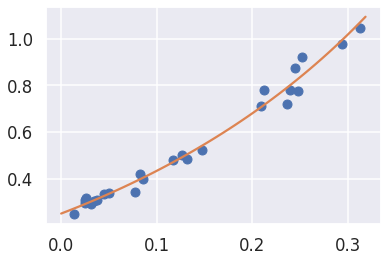

k_max = 0
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.807 (in total 250000 steps)
Shape of samples:  (250000, 1)
a_0 = 0.5467 + 0.5509 - 0.5552

k_max = 1
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.714 (in total 250000 steps)
Shape of samples:  (250000, 2)
a_0 = 0.1952 + 0.2028 - 0.2106
a_1 = 2.4685 + 2.5144 - 2.5605

k_max = 2
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.647 (in total 250000 steps)
Shape of samples:  (250000, 3)
a_0 = 0.2391 + 0.2510 - 0.2629
a_1 = 1.3132 + 1.5089 - 1.7038
a_2 = 2.6765 + 3.2997 - 3.9199

k_max = 3
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.594 (in total 250000 steps)
Shape of samples:  (250000, 4)
a_0 = 0.2276 + 0.2497 - 0.2715
a_1 = 0.9333 + 1.5592 - 2.1886
a_2 = -1.3934 + 2.8993 - 7.1907
a_3 = -7.5400 + 0

In [27]:
x_n, data_n, sigma_n = generate_data(25, 0.05)
m = len(x_n)
x_n = x_n.reshape(m,1)
data_n = data_n.reshape(m,1)
sigma_n = sigma_n.reshape(m,1)
plt.plot(x_n, data_n, 'o')
xx = np.linspace(0, 1/np.pi)
plt.plot(xx, (1/2 + np.tan(np.pi/2*xx))**2)
plt.show()

params_flat_n = []
samples_flat_n = []

for k in range(1,8):
    print(f"k_max = {k-1}")
    samples = sample_probabilities(k, x_n, data_n, sigma_n, prior=log_prior_uniform, max_t=500000, 
                                   nburn=1000 ,nsteps=5000)
    samples_flat_n.append(samples)
    m, a, p = np.percentile(samples, [16, 50, 84], axis=0)
    for i in range(k):
        print("a_{:} = {:2.4f} + {:2.4f} - {:2.4f}".format(i, m[i],a[i],p[i]))
    params_flat_n.append([a, m, p])
    print("")

samples_normal_n = []
params_normal_n = []

for k in range(1,8):
    print(f"k_max = {k-1}")
    samples = sample_probabilities(k, x_n, data_n, sigma_n, prior=log_prior_gaussian, nburn=1000, nsteps=5000)
    samples_normal_n.append(samples)
    m, a, p = np.percentile(samples, [16, 50, 84], axis=0)
    params_normal_n.append([a,m,p])
    for i in range(k):
        print("a_{:} = {:2.4f} + {:2.4f} - {:2.4f}".format(i, m[i],a[i],p[i]))
    print("")

In [37]:
chi_sq_dof_n = calc_chi_squared(x_n, data_n, sigma_n, params_flat_n)
evid_n = eval_evidence(x_n, data_n, sigma_n, params_normal_n)
create_table(params_flat_n, params_normal_n, chi_sq_dof_n, evid_n)

k_max = 0, evidence = 0
k_max = 1, evidence = 8.24e+13
k_max = 2, evidence = 8.68e+18
k_max = 3, evidence = 7.08e+18
k_max = 4, evidence = 6.73e+18
k_max = 5, evidence = 6.67e+18
k_max = 6, evidence = 6.65e+18
k & k_max & chi^2 &      a_0      &       a_1        &        a_2       &  Evid. &       a_0     &      a_1     &      a_2
------------------------------------------------------------------------------------------------------------------------
0 &   0   &  124.0 & 0.55 +/- 0.00 &                  &                  &      0 & 0.55 +/- 0.00 &
1 &   1   &   1.5 & 0.20 +/- 0.01 &   2.51 +/-  0.05 &                  &  8e+13 & 0.20 +/- 0.01 &2.51 +/- 0.05 &
2 &   2   &   0.3 & 0.25 +/- 0.01 &   1.51 +/-  0.20 &   3.30 +/-  0.62 &  9e+18 & 0.25 +/- 0.01 &1.52 +/- 0.19 & 3.25 +/- 0.61
2 &   3   &   0.3 & 0.25 +/- 0.02 &   1.56 +/-  0.63 &   2.90 +/-  4.29 &  7e+18 & 0.25 +/- 0.01 &1.60 +/- 0.33 & 2.68 +/- 2.04
2 &   4   &   0.3 & 0.26 +/- 0.04 &   1.05 +/-  1.85 &   9.29 +/- 22.53 &  7

#### Larger Error

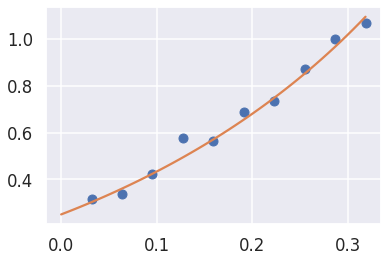

k_max = 0
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.806 (in total 500000 steps)
Shape of samples:  (500000, 1)
a_0 = 0.4915 + 0.5276 - 0.5637

k_max = 1
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.716 (in total 500000 steps)
Shape of samples:  (500000, 2)
a_0 = 0.1201 + 0.2514 - 0.3830
a_1 = 1.0683 + 1.9677 - 2.8675

k_max = 2
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.647 (in total 500000 steps)
Shape of samples:  (500000, 3)
a_0 = 0.1285 + 0.2695 - 0.4096
a_1 = 0.1950 + 1.5996 - 2.9882
a_2 = -3.0075 + 1.6337 - 6.2446

k_max = 3
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.594 (in total 500000 steps)
Shape of samples:  (500000, 4)
a_0 = 0.1313 + 0.2719 - 0.4113
a_1 = 0.1900 + 1.5669 - 2.9432
a_2 = -3.0195 + 1.6213 - 6.2020
a_3 = -4.3029 + 

In [29]:
x_l, data_l, sigma_l = generate_data(10, 0.25)
plt.plot(x_l, data_l, 'o')
xx = np.linspace(0, 1/np.pi)
plt.plot(xx, (1/2 + np.tan(np.pi/2*xx))**2)
plt.show()

samples_normal_l = []
params_normal_l = []

for k in range(1,8):
    print(f"k_max = {k-1}")
    samples = sample_probabilities(k, x_l, data_l, sigma_l, prior=log_prior_gaussian, nburn=1000, nsteps=10000)
    samples_normal_l.append(samples)
    m, a, p = np.percentile(samples, [16, 50, 84], axis=0)
    params_normal_l.append([a,m,p])
    for i in range(k):
        print("a_{:} = {:2.4f} + {:2.4f} - {:2.4f}".format(i, m[i],a[i],p[i]))
    print("")
    
params_flat_l = []
samples_flat_l = []

for k in range(1,8):
    print(f"k_max = {k-1}")
    samples = sample_probabilities(k, x_l, data_l, sigma_l, prior=log_prior_uniform, max_t=500000, 
                                   nburn=1000 ,nsteps=10000)
    samples_flat_l.append(samples)
    m, a, p = np.percentile(samples, [16, 50, 84], axis=0)
    for i in range(k):
        print("a_{:} = {:2.4f} + {:2.4f} - {:2.4f}".format(i, m[i],a[i],p[i]))
    params_flat_l.append([a, m, p])
    print("")



In [38]:
chi_sq_dof_l = calc_chi_squared(x_l, data_l, sigma_l, params_flat_l) 
evid_l = eval_evidence(x_l, data_l, sigma_l, params_normal_l)
create_table(params_flat_l, params_normal_l, chi_sq_dof_l, evid_l)

k_max = 0, evidence = 0.651
k_max = 1, evidence = 1.2
k_max = 2, evidence = 1.18
k_max = 3, evidence = 1.18
k_max = 4, evidence = 1.18
k_max = 5, evidence = 1.18
k_max = 6, evidence = 1.18
k & k_max & chi^2 &      a_0      &       a_1        &        a_2       &  Evid. &       a_0     &      a_1     &      a_2
------------------------------------------------------------------------------------------------------------------------
0 &   0   &   0.9 & 0.53 +/- 0.04 &                  &                  &    0.7 & 0.53 +/- 0.04 &
1 &   1   &   0.4 & 0.24 +/- 0.13 &   2.02 +/-  0.92 &                  &      1 & 0.25 +/- 0.13 &1.97 +/- 0.90 &
2 &   2   &   0.3 & 0.39 +/- 0.22 &  -0.87 +/-  3.54 &  12.43 +/- 14.58 &      1 & 0.27 +/- 0.14 &1.60 +/- 1.40 & 1.63 +/- 4.63
2 &   3   &   0.2 & 0.23 +/- 0.27 &   5.47 +/-  7.26 & -47.55 +/- 62.21 &      1 & 0.27 +/- 0.14 &1.57 +/- 1.38 & 1.62 +/- 4.61
2 &   4   &   0.3 & 0.29 +/- 0.31 &  -2.83 +/- 20.93 & 112.42 +/- 384.41 &      1 & 0.27 +/- 0.14 